In [91]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import gzip
from tinygrad.tensor import Tensor
from tinygrad.helpers import fetch

In [6]:
def _fetch_mnist(file, offset): return Tensor(gzip.open(fetch("https://storage.googleapis.com/cvdf-datasets/mnist/"+file)).read()[offset:])
def mnist():
  return _fetch_mnist("train-images-idx3-ubyte.gz", 0x10).reshape(-1, 1, 28, 28), _fetch_mnist("train-labels-idx1-ubyte.gz", 8), \
         _fetch_mnist("t10k-images-idx3-ubyte.gz", 0x10).reshape(-1, 1, 28, 28), _fetch_mnist("t10k-labels-idx1-ubyte.gz", 8)

In [7]:
train_imgs, train_lbs, test_imgs, test_lbs = mnist()
train_imgs, train_lbs, test_imgs, test_lbs = train_imgs.numpy(), train_lbs.numpy(), test_imgs.numpy(), test_lbs.numpy()

label is: 5


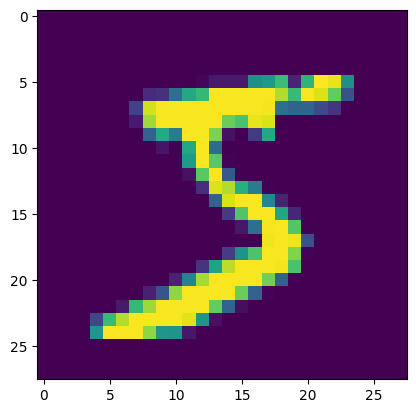

In [8]:
plt.imshow(train_imgs[0].reshape(28,28,1))
print(f"label is: {train_lbs[0]}")

trainy = train_imgs[0]

In [107]:
N_INPUT = 784
N_HIDDEN_1 = 128
N_HIDDEN_2 = 20
N_OUT = 10
LR = 0.001

def flatten(_imgs: np.ndarray) -> np.ndarray:
    images = []
    for img in _imgs:
        flat_train = np.zeros(img.shape[1]**2)
        ind = 0
        for c in img: # iterate over channels, although we only have one here
            for i in c: # iterate over rows
                for p in i: # iterate over pixels
                    flat_train[ind] = p
                    ind += 1
        images.append(flat_train)
    return np.asarray(images)


def relu(x: float) -> float:
    return float(max(0, x))


def hidden_layer(_input: np.ndarray, weights_mat: np.ndarray, bias: np.ndarray, last: bool = False) -> tuple[np.ndarray]:
    n_input = weights_mat.shape[0]
    n_output = weights_mat.shape[1]
    z = np.zeros(n_output)
    a = np.zeros(n_output)

    for i in range(n_input):
        for j in range(n_output):
            z[j] += _input[i] * weights_mat[i,j]
        z[j] += bias[j]

    if not last:
        for i in range(n_output):
            a[i] = relu(z[i])
    else:
        a = softmax(z)

    return z, a


def onehot(label):
    vec = np.zeros(N_OUT)
    vec[label] = 1
    return vec


def softmax(preds: np.ndarray) -> np.ndarray:
    logits = np.zeros_like(preds)
    exp_preds = np.zeros_like(preds)
    sum_exp = 0
    max_pred = max(preds)

    for i in range(len(preds)):
        exp_preds[i] = np.exp(preds[i] - max_pred)
        sum_exp += exp_preds[i]

    for i in range(len(preds)):
        logits[i] = exp_preds[i] / sum_exp

    return logits


def cross_entropy_loss(pred: np.ndarray, target: np.ndarray) -> np.ndarray:
    eps = 1e-15
    L = 0
    for i in range(N_OUT):
        L += target[i] * np.log(pred[i] + eps)
    return -L

def backward_out(logits: np.ndarray, label: np.ndarray) -> tuple[np.ndarray]:
    dz = logits - label
    dw = np.transpose(logits) * dz
    db = dz
    return dw, db
    

def backward_hidden(inputs: np.ndarray, weights_prev: np.ndarray, dz_prev: np.ndarray) -> tuple[np.ndarray]:
    da = dz_prev * np.transpose(weights_prev)
    dz = da
    dw = np.transpose(inputs) * dz
    db = dz
    return dw, db


def update(params: np.ndarray, grads: np.ndarray, lr: float) -> np.ndarray:
    try:
        for i in range(params.shape[0]):
            for j in range(params.shape[1]):
                params[i,j] = params[i,j] - lr * grads[i,j]
    except IndexError:
        for i in range(params.shape[0]):
            params[i] = params[i] - lr * grads[i]
    return params



In [ ]:
x_train = flatten(train_imgs)

In [109]:
weights_1 = np.random.randn(N_INPUT, N_HIDDEN_1) * 0.01
bias_1 = np.zeros(N_HIDDEN_1)

weights_2 = np.random.randn(N_HIDDEN_1, N_OUT) * 0.01
bias_2 = np.zeros(N_HIDDEN_2)

In [110]:
epoch_loss = []
for i in range(x_train.shape[0]):
    one_hot_label = onehot(train_lbs[i])
    z1, a1 = hidden_layer(x_train[i], weights_1, bias_1, last=False)
    z2, logits = hidden_layer(a1, weights_2, bias_2, last=True)
    loss = cross_entropy_loss(logits, one_hot_label)
    epoch_loss.append(loss)
    grad_w2, grad_b2 = backward_out(logits, one_hot_label)
    grad_w1, grad_b1 = backward_hidden(x_train[i], weights_2, grad_b2)
    weights_1 = update(weights_1, grad_w1, LR)
    weights_2 = update(weights_2, grad_w2, LR)
    bias_1 = update(bias_1, grad_b1, LR)
    bias_2 = update(bias_2, grad_b2, LR)
    if i%1000 == 0:
        print(f"Progress: {round((i+1) / x_train.shape[0] * 100)} % | loss: {round(sum(epoch_loss) / len(epoch_loss))}")

    

ValueError: operands could not be broadcast together with shapes (10,) (10,128) 

In [111]:
print(logits.shape)
print(train_lbs[i])

(10,)
5
